# Ovrlpy applied to vizgen receptor data map



#### Imports:

In [1]:
%load_ext autoreload
%autoreload 2

#### Parameter definition:

In [2]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)


5.71180135011673e-05


In [3]:
n_slice = 2

coordinate_path = f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/detected_transcripts_S{n_slice}R1.csv'
# analysis/tiesmeys/data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/detected_transcripts_S1R1.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
# model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [4]:

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


           global_x      global_y      global_z
count  4.874067e+07  4.874067e+07  4.874067e+07
mean   4.974135e+03  3.696136e+03  2.847259e+00
std    2.237596e+03  1.731014e+03  1.945633e+00
min    5.302726e+01 -7.666222e+01  0.000000e+00
25%    3.236294e+03  2.256036e+03  1.000000e+00
50%    4.957519e+03  3.637856e+03  3.000000e+00
75%    6.799679e+03  5.120410e+03  4.000000e+00
max    9.692914e+03  7.453246e+03  6.000000e+00
n_transcripts: 48574461, panel_size: 483


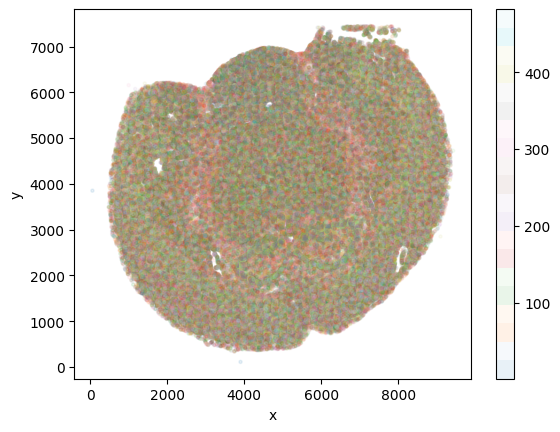

In [5]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

import time

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(df.describe())


df.columns=['x','y','z','gene']
df = df[~df.gene.str.contains('Blank')]
# df.x-=df.x.min()
# df.y-=df.y.min()
# df.x/=um_per_pixel/scale
# df.y/=um_per_pixel/scale
# df.z/=um_per_pixel/scale

# df.gene.replace({'Acte1':'Gm498'})

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = list(gene_counts.index)

df[::200].plot.scatter(x='x',y='y',s=5,c=df[::200].gene.cat.codes,cmap='tab20',alpha=0.1)

print(f"n_transcripts: {len(df)}, panel_size: {len(genes)}")

In [6]:
signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 
signatures.columns=signatures.columns.str.replace('/','-')


/tmp/ipykernel_453138/2048503760.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


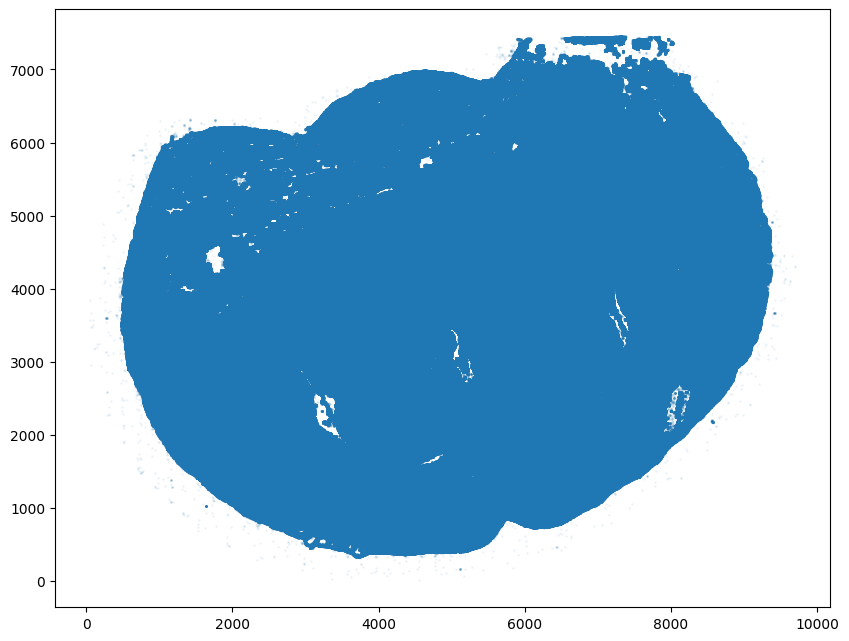

In [7]:
#
plt.figure(figsize=(10,10))


x_lims = [0,10000]
y_lims = [0,10000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask].copy()

mins = df[['x','y']].min()

# df.x-=df.x.min()
# df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1,alpha=0.05)
plt.gca().set_aspect('equal') 
df.gene = df.gene.astype('str').astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index

# Adhere to project's global naming convention:
coordinate_df = df.copy()
del df


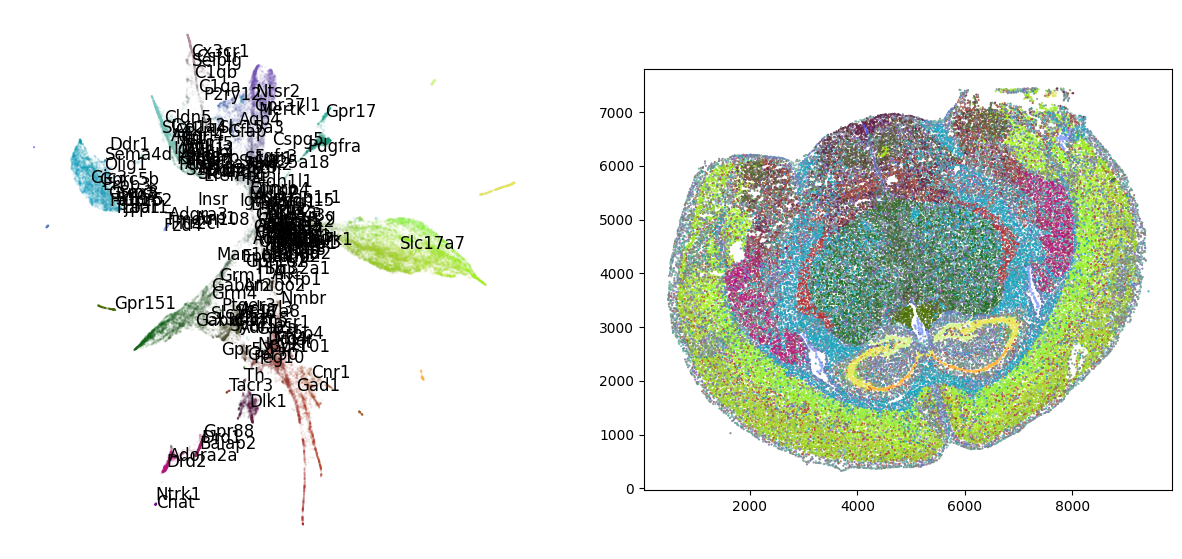

In [8]:
import ovrlpy

visualizer = ovrlpy.load_visualizer('./publication/vizgen-receptor/vizgen-receptor.vis')

signal_integrity,signal_strength = visualizer.integrity_map,visualizer.signal_map

visualizer.plot_fit()

/tmp/ipykernel_453138/1398008384.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


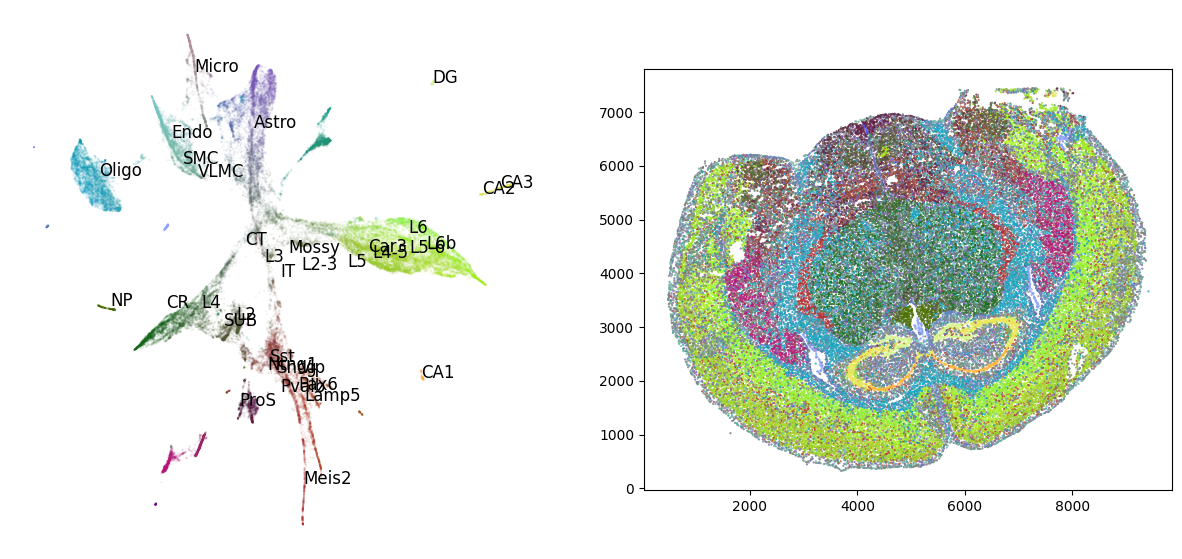

In [9]:
import numpy as np
import matplotlib.pyplot as plt

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in visualizer.genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

plt.savefig("./publication/vizgen-receptor/figures/receptor-fit",dpi=300)

In [10]:
visualizer.pseudocell_locations_x.max(),signal_integrity.shape

(np.float64(9416.0), (7454, 9693))

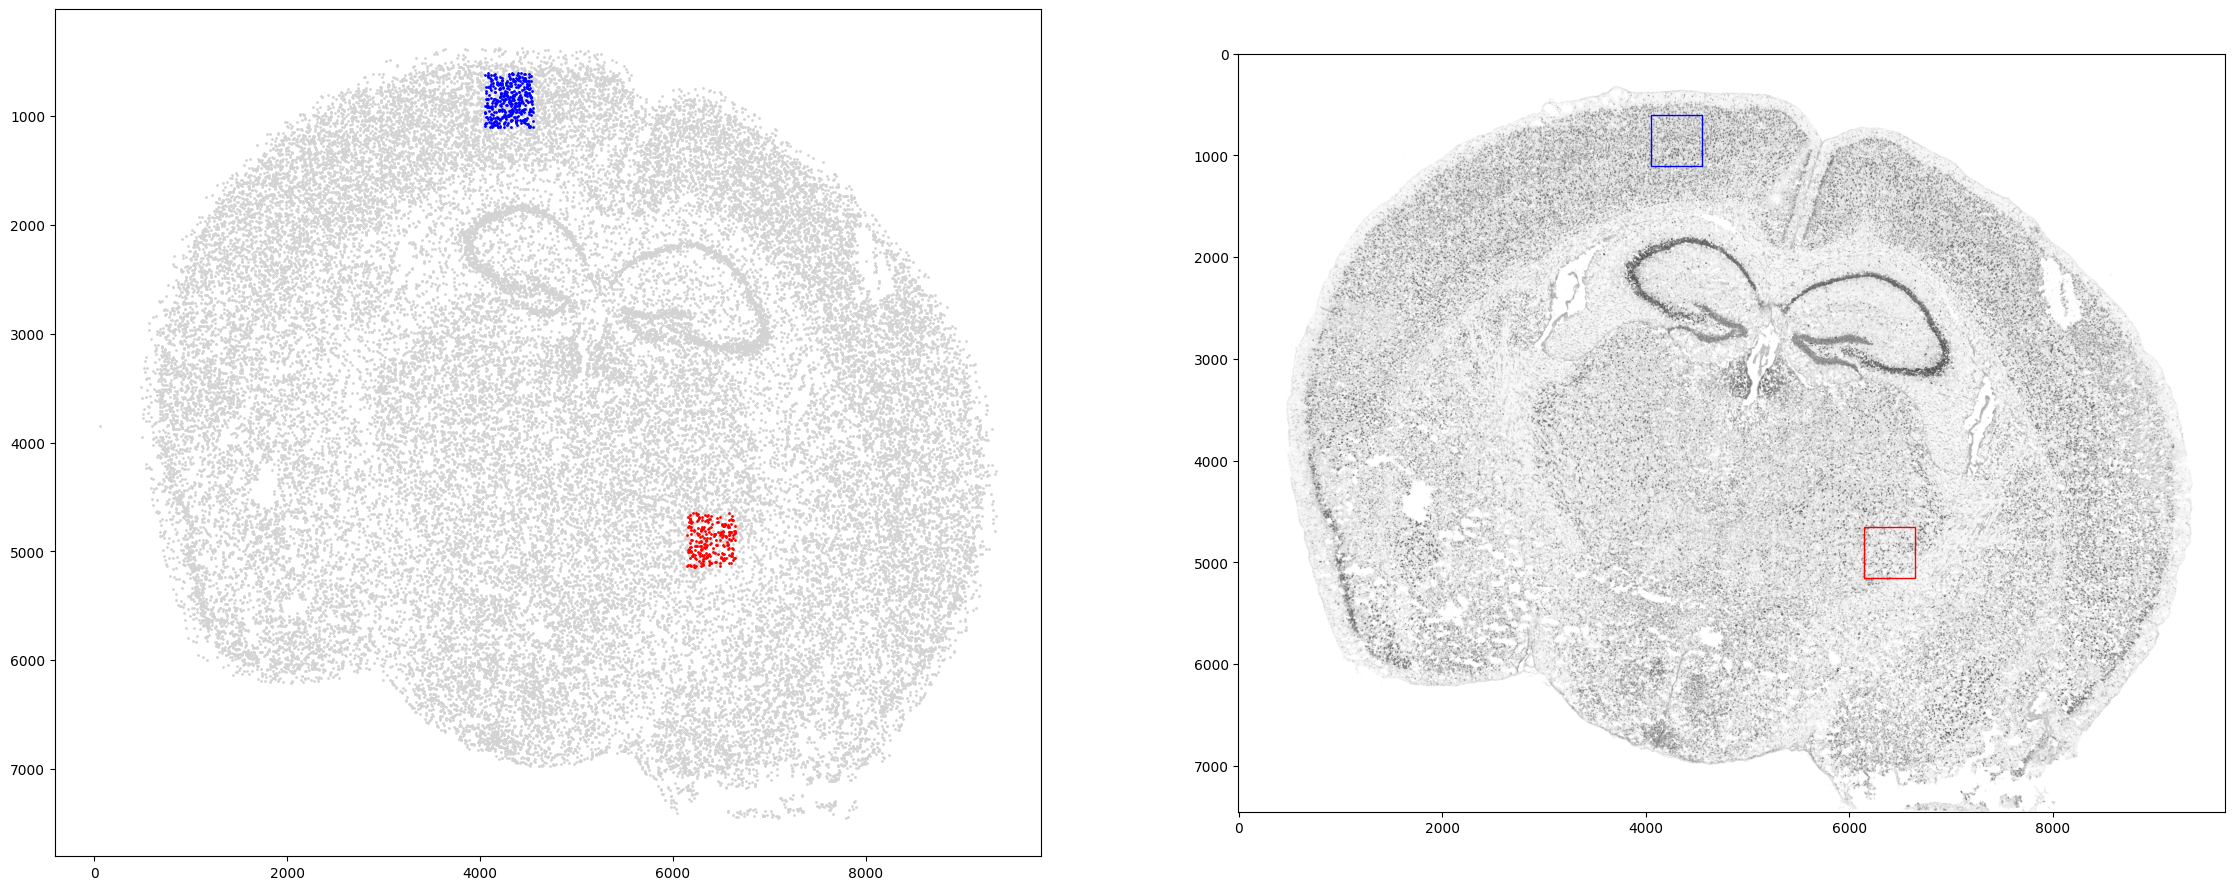

In [12]:

# crop out a central part of the tissue to create artificial overlaps:
xb_,yb_ = 4100/2*3, 3100/2*3
xt_,yt_ = 2700/2*3,400/2*3

width = 501

_xb = xb_+width
_xt = xt_+width
_yb = yb_+width
_yt = yt_+width

fold_bottom_mask = coordinate_df.x.between(xb_,_xb)&coordinate_df.y.between(yb_,_yb)
fold_top_mask = coordinate_df.x.between(xt_,_xt)&coordinate_df.y.between(yt_,_yt)

fold_df_bottom = coordinate_df[fold_bottom_mask].copy()
fold_df_bottom['fold'] = 'bottom'
fold_df_top = coordinate_df[fold_top_mask].copy()
fold_df_top['fold'] = 'top'

plt.figure(figsize=(28,11))

ax = plt.subplot(121)
plt.scatter(coordinate_df.x[::1000],coordinate_df.y[::1000],c='lightgrey',s=1)
plt.scatter(fold_df_bottom.x[::1000],fold_df_bottom.y[::1000],c='r',s=1)
plt.scatter(fold_df_top.x[::1000],fold_df_top.y[::1000],c='b',s=1)
ax.invert_yaxis()

ax = plt.subplot(122)
plt.imshow(signal_strength**0.5, cmap='Greys')
rect_b = plt.Rectangle((xb_,yb_),width,width,edgecolor='r',facecolor='none')
ax.add_artist(rect_b)
rect_t = plt.Rectangle((xt_,yt_),width,width,edgecolor='b',facecolor='none')
ax.add_artist(rect_t)

# move the signal to origin
fold_df_bottom.x-=xb_
fold_df_top.x-=xt_

fold_df_bottom.y-=yb_
fold_df_top.y-=yt_

ovrlpy.pre_process_coordinates(fold_df_bottom)
ovrlpy.pre_process_coordinates(fold_df_top)

fold_df_folded = fold_df_bottom.copy()
fold_df_folded.z-=fold_df_bottom.z.max()-fold_df_top.z.min()
fold_df_folded = pd.concat([fold_df_folded,fold_df_top])

ovrlpy.pre_process_coordinates(fold_df_folded)

fold_bottom_centroids = visualizer.pseudocell_df()[visualizer.pseudocell_df().x.between(xt_,_xt-1)&visualizer.pseudocell_df().y.between(yt_,_yt-1)][['x','y']]
fold_top_centroids = visualizer.pseudocell_df()[visualizer.pseudocell_df().x.between(xb_,_xb-1)&visualizer.pseudocell_df().y.between(yb_,_yb-1)][['x','y']]

fold_bottom_centroids -= [xt_,yt_]
fold_top_centroids -= [xb_,yb_]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.80s/it]


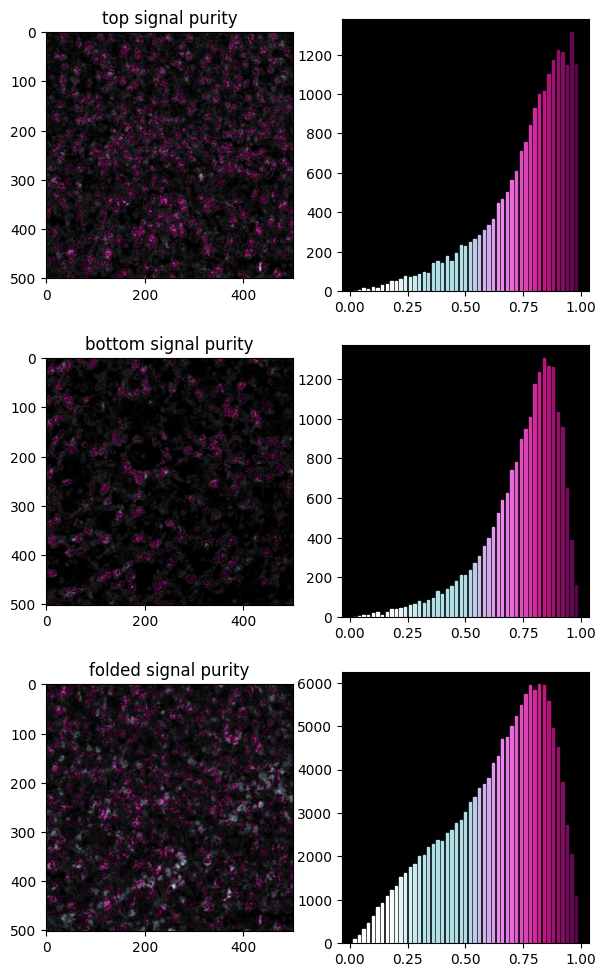

In [14]:
from ovrlpy._utils import _compute_divergence_patched  
from ovrlpy._ovrlp import _BIH_CMAP as cmap

min_expression = 1.5


coherence_bottom, signal_bottom = _compute_divergence_patched(fold_df_bottom, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

coherence_top, signal_top = _compute_divergence_patched(fold_df_top, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

coherence_folded, signal_folded = _compute_divergence_patched(fold_df_folded, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

fold_bottom_centroids = pd.DataFrame(np.where(signal_bottom>1),index=['x','y']).T
fold_top_centroids = pd.DataFrame(np.where(signal_top>1),index=['x','y']).T

def plot_purity_distribution(coherence,ax=None):
    if ax is None:
        ax = plt.gca()
    vals,bins = np.histogram(coherence, bins=50, range=(0,1))
    colors = cmap(bins[1:-1])
    bars = ax.bar(bins[1:-1],vals[1:],width=0.01)
    for i,bar in enumerate(bars):
        bar.set_color(colors[i])

fig = plt.figure(figsize=(7,12))

ax = plt.subplot(321,facecolor='k')
plt.title('top signal purity')
plt.imshow(coherence_top.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_top.T/signal_top.max(), interpolation='nearest')
ax = plt.subplot(324,facecolor='k')
plot_purity_distribution(coherence_top[signal_bottom>1.5],ax=ax)

ax = plt.subplot(323,facecolor='k')
plt.title('bottom signal purity')
plt.imshow(coherence_bottom.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_bottom.T/signal_bottom.max(), interpolation='nearest')
ax = plt.subplot(322,facecolor='k')
plot_purity_distribution(coherence_bottom[signal_top>1.5],ax=ax)

ax = plt.subplot(325,facecolor='k')
plt.title('folded signal purity')
plt.imshow(coherence_folded.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_folded.T/signal_folded.max(), interpolation='nearest')
ax = plt.subplot(326,facecolor='k')
plot_purity_distribution(coherence_folded[signal_folded>1.5],ax=ax)



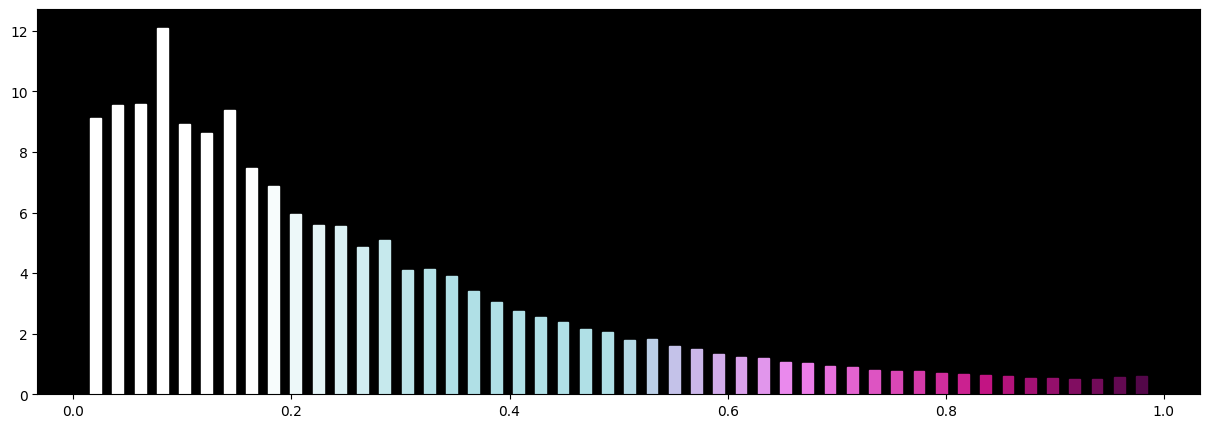

In [15]:
hist_top, bins,  = np.histogram(coherence_top[signal_top>1.5],bins=np.linspace(0,1,50),density=True)
hist_bot, bins,  = np.histogram(coherence_bottom[signal_bottom>1.5],bins=np.linspace(0,1,50),density=True)
hist_folded, bins,  = np.histogram(coherence_folded[signal_folded>1.5],bins=np.linspace(0,1,50),density=True)
hist_quotient = hist_folded/hist_top

plt.figure(figsize=(15,5))

ax = plt.subplot(111,facecolor='k')
colors = cmap(bins[1:-1])
bars = ax.bar(bins[1:-1],hist_quotient[1:],width=0.01)
for i,bar in enumerate(bars):
    bar.set_color(colors[i])
    
# ax.set_yscale('log')
# plt.hlines(10,0,1,linestyles='dashed',color='w')
# plt.vlines(0.48,0,500,linestyles='dashed',color='w')